In [2]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from rff.layers import GaussianEncoding #pip install random-fourier-features-pytorch
from sklearn.metrics import accuracy_score, f1_score, recall_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
import os
import optuna
from optuna.trial import TrialState
from tab_transformer_pytorch import FTTransformer, TabTransformer
import sys
import time
from torch import Tensor
from typing import Literal

device_in_use='cuda'

c:\Users\smbm2\AppData\Local\miniconda3\envs\ml-env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# df_train = pd.read_csv('/home/cscadmin/CyberResearch/CAT-Transformer/datasets/covertype/train.csv')
# df_test = pd.read_csv('/home/cscadmin/CyberResearch/CAT-Transformer/datasets/covertype/test.csv')
# df_val = pd.read_csv('/home/cscadmin/CyberResearch/CAT-Transformer/datasets/covertype/validation.csv') #READ FROM RIGHT SPOT

df_train = pd.read_csv(r'C:\Users\smbm2\projects\CAT-Transformer\datasets\covertype\train.csv')
df_test = pd.read_csv(r'C:\Users\smbm2\projects\CAT-Transformer\datasets\covertype\test.csv')
df_val = pd.read_csv(r'C:\Users\smbm2\projects\CAT-Transformer\datasets\covertype\validation.csv') #READ FROM RIGHT SPOT

In [5]:
cont_columns = ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
       'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5',
       'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10',
       'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14',
       'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18',
       'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22',
       'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26',
       'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30',
       'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34',
       'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38',
       'Soil_Type39', 'Soil_Type40']
target = ['Cover_Type']

#CHECKING TO MAKE SURE YOUR LIST IS CORRECT (NO NEED TO TOUCH)
yourlist = cont_columns + target
yourlist.sort()
oglist = list(df_train.columns)
oglist.sort()

assert(yourlist == oglist), "You may of spelled feature name wrong or you forgot to put on of them in the list"

target_classes = [max(len(df_train[target].value_counts()), len(df_val[target].value_counts()),len(df_test[target].value_counts()))]
print(target_classes)
# Create a StandardScaler and fit it to the cont features
scaler = StandardScaler()
scaler.fit(df_train[cont_columns])

# Transform the training, test, and validation datasets
df_train[cont_columns] = scaler.transform(df_train[cont_columns])
df_test[cont_columns] = scaler.transform(df_test[cont_columns])
df_val[cont_columns] = scaler.transform(df_val[cont_columns])

class SingleTaskDataset(Dataset):
    def __init__(self, df : pd.DataFrame, num_columns,task1_column):
        self.n = df.shape[0]
        
        self.task1_labels = df[task1_column].astype(np.int64).values

        self.num = df[num_columns].astype(np.float32).values


    def __len__(self):
        return self.n
    
    def __getitem__(self, idx):
        # Retrieve features and labels from the dataframe using column names
        num_features = self.num[idx]
        labels_task1 = self.task1_labels[idx]

        return num_features, labels_task1

#Wrapping in Dataset
train_dataset = SingleTaskDataset(df_train, cont_columns, 'Cover_Type')
val_dataset = SingleTaskDataset(df_val, cont_columns, 'Cover_Type')
test_dataset = SingleTaskDataset(df_test, cont_columns, 'Cover_Type')

#This is a hyperparameter that is not tuned. Maybe mess with what makes sense here
#Also try looking to see what other papers have done
batch_size = 256

# Wrapping with DataLoader for easy batch extraction
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

[7]


In [6]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

class MultiHeadAttention(nn.Module):
    def __init__(self, embed_size, heads):
        super(MultiHeadAttention, self).__init__()

        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads
        assert(self.head_dim * heads == embed_size), "Embed size needs to be div by heads"
        self.values = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.keys =nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.queries = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.fc_out = nn.Linear(heads*self.head_dim, embed_size)


    def forward(self, values, keys, query):
        N = query.shape[0]
        value_len, key_len, query_len = values.shape[1], keys.shape[1], query.shape[1]

        values = values.reshape(N, value_len, self.heads, self.head_dim)
        keys = keys.reshape(N, key_len, self.heads, self.head_dim)
        queries = query.reshape(N, query_len, self.heads, self.head_dim)

        values = self.values(values)
        keys = self.keys(keys)
        queries = self.queries(queries)

        energy = torch.einsum("nqhd,nkhd->nhqk", [queries, keys])

        attention = torch.softmax(energy / (self.embed_size ** (1/2)), dim=3) #(batch_size, head_dim, #query_embeddings, #key_embeddings)

        # Calculate simplified attention scores
        avg_attention = attention.mean(dim=0)  # Average across batches
        # print("batch average", avg_attention.shape)
        avg_attention = avg_attention.mean(dim=0).squeeze(dim=0)
        # print("head average", avg_attention.shape)

        out = torch.einsum("nhql,nlhd->nqhd", [attention, values]).reshape(N, query_len, self.heads*self.head_dim) #(batch_size, n_features, embed_size)
        out = self.fc_out(out)

        return out, avg_attention
    
class TransformerBlock(nn.Module):
    def __init__(self, embed_size, heads, dropout, forward_expansion, pre_norm_on):
        super(TransformerBlock, self).__init__()

        self.pre_norm_on = pre_norm_on
        if self.pre_norm_on:
            self.pre_norm = nn.LayerNorm(embed_size)
        self.attention = MultiHeadAttention(embed_size, heads)
        self.norm1 = nn.LayerNorm(embed_size)
        self.norm2 = nn.LayerNorm(embed_size)

        self.feed_forward = nn.Sequential(nn.Linear(embed_size, forward_expansion*embed_size),
                                          nn.ReLU(),
                                          nn.Linear(forward_expansion*embed_size, embed_size)
                                          )
        self.dropout = nn.Dropout(dropout)

    def forward(self,value,key,query):
        if self.pre_norm_on:
            query = self.pre_norm(query)
            key = self.pre_norm(key)
            value = self.pre_norm(value)
            
        attention, avg_attention = self.attention(value, key, query)
        x = self.dropout(self.norm1(attention + query))
        forward = self.feed_forward(x)
        out = self.dropout(self.norm2(forward + x))
        return out, avg_attention
    
class DecoderBlock(nn.Module):
    def __init__(self, embed_size, heads, forward_expansion, dropout, pre_norm_on):
        super(DecoderBlock, self).__init__()

        self.attention = MultiHeadAttention(embed_size, heads)
        self.norm = nn.LayerNorm(embed_size)
        self.transformer_block = TransformerBlock(embed_size, heads, dropout, forward_expansion, pre_norm_on)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, value, key):
        out, avg_attention = self.transformer_block(value, key, x)

        return out, avg_attention

class Decoder(nn.Module):
    def __init__(self,
                 embed_size,
                 num_layers,
                 heads,
                 forward_expansion,
                 decoder_dropout,
                 pre_norm_on
    ):
        super(Decoder, self).__init__()

        self.layers = nn.ModuleList(
                [
                    DecoderBlock(
                        embed_size,
                        heads,
                        dropout=decoder_dropout,
                        forward_expansion=forward_expansion,
                        pre_norm_on=pre_norm_on
                    )
                    for _ in range(num_layers)
                ]
            )
        self.avg_attention = None

    def forward(self, class_embed, context):
        for layer in self.layers:
            # x is the classification embedding (CLS Token)
            # context are the feature embeddings that will be used as key and value
            x, self.avg_attention = layer(class_embed, context, context)
  
        return x 

class EmbeddingsRFFforIndividualFeatures(nn.Module):
    def __init__(self, sigma, embed_size, input_size, n_cont,  num_target_labels, rff_on, linear_on:bool):
        super(EmbeddingsRFFforIndividualFeatures, self).__init__()

        self.rff_on = rff_on

        self.linear_on = linear_on

        if self.rff_on:
            self.rffs = nn.ModuleList([GaussianEncoding(sigma=sigma, input_size=input_size, encoded_size=embed_size//2) for _ in range(n_cont)])
            self.mlp_in = embed_size
        else:
            self.mlp_in = input_size

        if self.linear_on:
            self.cont_embeddings = nn.ModuleList([nn.Linear(in_features=self.mlp_in, out_features=embed_size) for _ in range(n_cont)])

        # Classifcation Embeddings for each target label
        self.target_label_embeddings = nn.ModuleList([nn.Embedding(1, embed_size) for _ in range(num_target_labels)])


    def forward(self, x):
        x = x.unsqueeze(2) #(batch_size, n_features) -> (batch_size, n_features, 1)
        rff_vectors = []
        if self.rff_on:
            for i, r in enumerate(self.rffs):
                input = x[:,i,:]
                out = r(input)
                rff_vectors.append(out)

        embeddings = []
        if self.linear_on:
            x = torch.stack(rff_vectors, dim=1)
            for i, e in enumerate(self.cont_embeddings):
                goin_in = x[:,i,:]
                goin_out = e(goin_in)
                embeddings.append(goin_out)
        else:
            embeddings = rff_vectors

        target_label_embeddings_ = []
        for e in self.target_label_embeddings:
            input = torch.tensor([0], device=x.device)
            temp = e(input)
            temp = temp.repeat(x.size(0), 1)
            tmep = temp.unsqueeze(1)
            target_label_embeddings_.append(temp)

        class_embeddings = torch.stack(target_label_embeddings_, dim=1)

        context = torch.stack(embeddings, dim=1)


        return class_embeddings, context

class EmbeddingsRFFforAllFeatures(nn.Module):
    def __init__(self, sigma, embed_size, input_size, n_cont, num_target_labels, rff_on, linear_on:bool):
        super(EmbeddingsRFFforAllFeatures, self).__init__()

        self.rff_on = rff_on
        self.n_cont = n_cont
        self.linear_on=linear_on

        if self.rff_on:
            self.rff = GaussianEncoding(sigma=sigma, input_size=input_size, encoded_size=embed_size//2) 
            self.mlp_in = embed_size
        else:
            self.mlp_in = input_size

        if self.linear_on:
            self.cont_embeddings = nn.ModuleList([nn.Linear(in_features=self.mlp_in, out_features=embed_size) for _ in range(n_cont)])

        
        # Classifcation Embeddings for each target label
        self.target_label_embeddings = nn.ModuleList([nn.Embedding(1, embed_size) for _ in range(num_target_labels)])


    def forward(self, x):
        x = x.unsqueeze(2) #(batch_size, n_features) -> (batch_size, n_features, 1)
        rff_vectors = []
        if self.rff_on:
            for i in range(self.n_cont):
                input = x[:,i,:]
                out = self.rff(input)
                rff_vectors.append(out)
        
        embeddings = []
        if self.linear_on:
            x = torch.stack(rff_vectors, dim=1)
            for i, e in enumerate(self.cont_embeddings):
                goin_in = x[:,i,:]
                goin_out = e(goin_in)
                embeddings.append(goin_out)
        else:
            embeddings = rff_vectors

        target_label_embeddings_ = []
        for e in self.target_label_embeddings:
            input = torch.tensor([0], device=x.device)
            temp = e(input)
            temp = temp.repeat(x.size(0), 1)
            tmep = temp.unsqueeze(1)
            target_label_embeddings_.append(temp)

        class_embeddings = torch.stack(target_label_embeddings_, dim=1)

        context = torch.stack(embeddings, dim=1)

        return class_embeddings, context
    
class PeriodicActivation(nn.Module):
    def __init__(self, sigma, embed_size, n_cont, num_target_labels,trainable: bool, initialization: str, linear_on:bool):
        super(PeriodicActivation, self).__init__()

        self.n = embed_size
        self.sigma = sigma
        self.trainable = trainable
        self.initialization = initialization
        self.linear_on = linear_on
        self.n_cont = n_cont

        if self.initialization == 'log-linear':
            coefficients = self.sigma ** (torch.arange(self.n//2) / self.n)
            coefficients = coefficients[None]
        else:
            assert self.initialization == 'normal'
            coefficients = torch.normal(0.0, self.sigma, (1, self.n//2))

        if self.trainable:
            self.coefficients = nn.Parameter(coefficients)
        else:
            self.register_buffer('coefficients', coefficients)

        if self.linear_on:
            self.cont_embeddings = nn.ModuleList([nn.Linear(in_features=embed_size, out_features=embed_size) for _ in range(n_cont)])

        
        # Classifcation Embeddings for each target label
        self.target_label_embeddings = nn.ModuleList([nn.Embedding(1, embed_size) for _ in range(num_target_labels)])


    def forward(self, x):
        x = x.unsqueeze(2) #(batch_size, n_features) -> (batch_size, n_features, 1)

        temp = []
        for i in range(self.n_cont):
            input = x[:,i,:]
            out = torch.cat([torch.cos(self.coefficients * input), torch.sin(self.coefficients * input)], dim=-1)
            temp.append(out)
        
        embeddings = []
        if self.linear_on:
            x = torch.stack(temp, dim=1)
            for i, e in enumerate(self.cont_embeddings):
                goin_in = x[:,i,:]
                goin_out = e(goin_in)
                embeddings.append(goin_out)
        else:
            embeddings = temp

        target_label_embeddings_ = []
        for e in self.target_label_embeddings:
            input = torch.tensor([0], device=x.device)
            temp = e(input)
            temp = temp.repeat(x.size(0), 1)
            tmep = temp.unsqueeze(1)
            target_label_embeddings_.append(temp)

        class_embeddings = torch.stack(target_label_embeddings_, dim=1)

        context = torch.stack(embeddings, dim=1)

        return class_embeddings, context


class classificationHead(nn.Module):
    def __init__(self, embed_size, dropout, mlp_scale_classification, num_target_classes):
        super(classificationHead, self).__init__()
        
        #flattening the embeddings out so each sample in batch is represented with a 460 dimensional vector
        self.input = embed_size
        self.lin1 = nn.Linear(self.input, mlp_scale_classification*self.input)
        self.drop = nn.Dropout(dropout)
        self.lin2 = nn.Linear(mlp_scale_classification*self.input, mlp_scale_classification*self.input)
        self.lin3 = nn.Linear(mlp_scale_classification*self.input, self.input)
        self.lin4 = nn.Linear(self.input, num_target_classes)
        self.relu = nn.ReLU()
        self.initialize_weights()

    def initialize_weights(self): #he_initialization.
        torch.nn.init.kaiming_normal_(self.lin1.weight, nonlinearity='relu')
        torch.nn.init.zeros_(self.lin1.bias)

        torch.nn.init.kaiming_normal_(self.lin3.weight, nonlinearity='relu')
        torch.nn.init.zeros_(self.lin3.bias)

    def forward(self, x):

        x= torch.reshape(x, (-1, self.input))

        x = self.lin1(x)
        x = self.relu(x)
        x = self.drop(x)
        x = self.lin2(x)
        x = self.relu(x)
        x = self.drop(x)
        x = self.lin3(x)
        x = self.relu(x)
        x = self.drop(x)
        x = self.lin4(x)
  
        return x

class CATTransformer(nn.Module):
    def __init__(self, 
                 rff_on = True,
                 sigma=4,
                 embed_size=20,
                 input_size=1,
                 n_cont = 0,
                 num_layers=1,
                 heads=1,
                 forward_expansion=4, # Determines how wide the MLP is in the encoder. Its a scaling factor. 
                 decoder_dropout=0,
                 classification_dropout = 0,
                 pre_norm_on = False,
                 mlp_scale_classification = 4,
                 targets_classes : list=  [3,8],
                embedding_scheme ="rff_unique",
                trainable=True,
                linear_on=True
                 ):
        super(CATTransformer, self).__init__()

        assert(embedding_scheme in ['rff_unique', 'rff', 'log-linear_periodic', 'normal_periodic']), "wrong embedding_scheme"

        if embedding_scheme == 'rff_unique':
            self.embeddings = EmbeddingsRFFforIndividualFeatures(rff_on=rff_on, sigma=sigma, embed_size=embed_size, input_size=input_size, 
                                     n_cont=n_cont, num_target_labels=len(targets_classes), linear_on=linear_on)
        elif embedding_scheme == 'log-linear_periodic':
            self.embeddings = PeriodicActivation(sigma=sigma, embed_size=embed_size, n_cont=n_cont, 
                                                 num_target_labels=len(target_classes),trainable=trainable,initialization='log-linear', linear_on=linear_on)
        elif embedding_scheme == 'normal_periodic':
            self.embeddings = PeriodicActivation(sigma=sigma, embed_size=embed_size, n_cont=n_cont, 
                                                 num_target_labels=len(target_classes),trainable=trainable,initialization='normal',linear_on=linear_on)
        else:
            self.embeddings = EmbeddingsRFFforAllFeatures(rff_on=rff_on, sigma=sigma, embed_size=embed_size, input_size=input_size, 
                                     n_cont=n_cont, num_target_labels=len(targets_classes),linear_on=linear_on)
            
        self.decoder = Decoder(embed_size=embed_size, num_layers=num_layers, heads=heads, forward_expansion=forward_expansion, 
                               decoder_dropout=decoder_dropout, pre_norm_on=pre_norm_on)
        self.classifying_heads = nn.ModuleList([classificationHead(embed_size=embed_size, dropout=classification_dropout, 
                                                                   mlp_scale_classification=mlp_scale_classification, 
                                                                   num_target_classes=x) for x in targets_classes])
        
    def forward(self, x):
        class_embed, context = self.embeddings(x)

        x = self.decoder(class_embed, context)
        
        probability_dist_raw = []
        for i, e in enumerate(self.classifying_heads):
            input = x[:, i,:]
            output = e(input)
            probability_dist_raw.append(output)
        
        return probability_dist_raw
    
    # Training and Testing Loops
def train(dataloader, model, loss_function, optimizer, device_in_use):
    model.train()

    total_loss = 0

    total_correct_1 = 0
    total_samples_1 = 0
    all_targets_1 = []
    all_predictions_1 = []

    total_correct_2 = 0
    total_samples_2 = 0
    all_targets_2 = []
    all_predictions_2 = []

    for (features,labels_task1) in dataloader:
        features,labels_task1 = features.to(device_in_use),labels_task1.to(device_in_use)


        task_predictions = model(features) #contains a list of the tensor outputs for each task

        loss = loss_function(task_predictions, labels_task1)
        total_loss += loss.item()

        #computing accuracy for first target
        y_pred_softmax_1 = torch.softmax(task_predictions[0], dim=1)
        _, y_pred_labels_1 = torch.max(y_pred_softmax_1, dim=1)
        total_correct_1 += (y_pred_labels_1 == labels_task1).sum().item()
        total_samples_1 += labels_task1.size(0)
        all_targets_1.extend(labels_task1.cpu().numpy())
        all_predictions_1.extend(y_pred_labels_1.cpu().numpy())

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    avg_loss = total_loss/len(dataloader)
    accuracy_1 = total_correct_1 / total_samples_1
    # accuracy_2 = total_correct_2 / total_samples_2

    # # precision = precision_score(all_targets, all_predictions, average='weighted')
    # recall = recall_score(all_targets, all_predictions, average='weighted')
    # f1 = f1_score(all_targets, all_predictions, average='weighted')

    return avg_loss, accuracy_1

def test(dataloader, model, loss_function, device_in_use):
  model.eval()
  total_loss = 0
  
  total_correct_1 = 0
  total_samples_1 = 0
  all_targets_1 = []
  all_predictions_1 = []

  total_correct_2 = 0
  total_samples_2 = 0
  all_targets_2 = []
  all_predictions_2 = []

  with torch.no_grad():
    for (features,labels_task1) in dataloader:
      features,labels_task1 = features.to(device_in_use),labels_task1.to(device_in_use)

      #compute prediction error
      task_predictions = model(features) #contains a list of the tensor outputs for each task

      loss = loss_function(task_predictions, labels_task1)
      total_loss += loss.item()

      #computing accuracy for first target
      y_pred_softmax_1 = torch.softmax(task_predictions[0], dim=1)
      _, y_pred_labels_1 = torch.max(y_pred_softmax_1, dim=1)
      total_correct_1 += (y_pred_labels_1 == labels_task1).sum().item()
      total_samples_1 += labels_task1.size(0)
      all_targets_1.extend(labels_task1.cpu().numpy())
      all_predictions_1.extend(y_pred_labels_1.cpu().numpy())

  avg = total_loss/len(dataloader)
  accuracy_1 = total_correct_1 / total_samples_1
  # accuracy_2 = total_correct_2 / total_samples_2
  # recall = recall_score(all_targets, all_predictions, average='weighted')
  f1_1 = f1_score(all_targets_1, all_predictions_1, average='weighted')
  # f1_2 = f1_score(all_targets_2, all_predictions_2, average="weighted")

  return avg, accuracy_1, all_predictions_1, all_targets_1, f1_1

def format_metric(value): # Used to format the metrics output
    return f"{value:.4f}"

# RFF to each feature - Linear

Epoch [ 1/100]       | Train: Loss 0.75028, Accuracy 0.68318                             | Test: Loss 0.64539, Accuracy 0.72699, F1 0.71596
Epoch [ 2/100]       | Train: Loss 0.61234, Accuracy 0.73685                             | Test: Loss 0.58496, Accuracy 0.74166, F1 0.72990
Epoch [ 3/100]       | Train: Loss 0.55445, Accuracy 0.75844                             | Test: Loss 0.51872, Accuracy 0.77521, F1 0.77084
Epoch [ 4/100]       | Train: Loss 0.49836, Accuracy 0.78449                             | Test: Loss 0.46708, Accuracy 0.80113, F1 0.79756
Epoch [ 5/100]       | Train: Loss 0.43858, Accuracy 0.81314                             | Test: Loss 0.39876, Accuracy 0.83490, F1 0.83331
Epoch [ 6/100]       | Train: Loss 0.37618, Accuracy 0.84268                             | Test: Loss 0.33414, Accuracy 0.86354, F1 0.86304
Epoch [ 7/100]       | Train: Loss 0.31626, Accuracy 0.87076                             | Test: Loss 0.27467, Accuracy 0.89026, F1 0.88962
Epoch [ 8/100]      

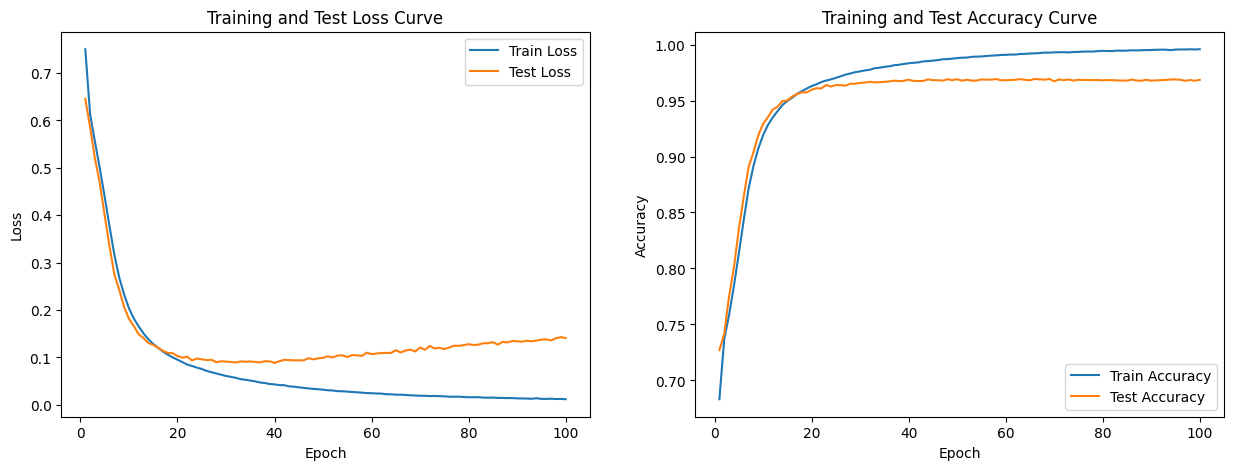

In [5]:
class LossFunction(nn.Module):
    def __init__(self, num_tasks):
        super(LossFunction, self).__init__()
        self.num_tasks = num_tasks

        self.loss_fns = [nn.CrossEntropyLoss() for x in range(num_tasks)] 

    def forward(self, predictions, labels_task1):

        #task 1
        target = labels_task1.long()
        prediction = predictions[0]
        loss_fn = self.loss_fns[0]

        task_loss = loss_fn(prediction, target)
        
        return task_loss
    
model = CATTransformer(rff_on=True,
                       sigma=2,
                       embed_size=160,
                       heads=5,
                       forward_expansion=8,
                       pre_norm_on=False,
                       mlp_scale_classification=8,
                       decoder_dropout=0,
                       classification_dropout=0.1,
                       targets_classes=target_classes,
                       n_cont=len(cont_columns),
                       embedding_scheme='rff_unique',
                       linear_on=True).to(device_in_use)

def format_metric(value): # Used to format the metrics output
    return f"{value:.5f}"

loss_functions = LossFunction(1)
optimizer = torch.optim.Adam(params=model.parameters(), lr = 0.0001) # Maybe try messing around with optimizers. try other torch optimizers with different configurations.
epochs = 100 #Set the number of epochs

train_losses = []
train_accuracies_1 = [] 
test_losses = []
test_accuracies_1 = [] 
test_f1_scores = [] 


#Time will be recorded for all 100 epochs - This means the results will not be comparable to Xgboost but that is ok, we will only compare between transformer models who will also train for 100 epochs
start_time = time.process_time()

for t in range(epochs):
  train_loss, train_accuracy_1 = train(train_dataloader, model, loss_functions, optimizer, device_in_use=device_in_use)
  test_loss, test_accuracy_1, all_predictions_1, all_targets_1, f1_1 = test(test_dataloader, model, loss_functions, device_in_use=device_in_use)
  train_losses.append(train_loss)
  train_accuracies_1.append(train_accuracy_1)
  # train_accuracies_2.append(train_accuracy_2)
  # train_recalls.append(train_recall) 
  # train_f1_scores.append(train_f1)
  test_losses.append(test_loss)
  test_accuracies_1.append(test_accuracy_1)
  # test_accuracies_2.append(test_accuracy_2)
  # test_recalls.append(test_recall)
  test_f1_scores.append(f1_1)
  # Formatting for easier reading
  epoch_str = f"Epoch [{t+1:2}/{epochs}]"
  train_metrics = f"Train: Loss {format_metric(train_loss)}, Accuracy {format_metric(train_accuracy_1)}"
  test_metrics = f"Test: Loss {format_metric(test_loss)}, Accuracy {format_metric(test_accuracy_1)}, F1 {format_metric(f1_1)}"
  print(f"{epoch_str:20} | {train_metrics:65} | {test_metrics}")

total_time = time.process_time() - start_time

# Plotting the loss curves
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), [l for l in test_losses], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curve')
plt.legend()

# Plotting the accuracy curves
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies_1, label='Train Accuracy')
plt.plot(range(1, epochs+1), test_accuracies_1, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy Curve')
plt.legend()

# Display confusion matrix for the first task (Traffic Type) on test data
conf_matrix_1 = confusion_matrix(all_targets_1, all_predictions_1)
print("Confusion Matrix for income")
print(conf_matrix_1)

best_index = test_accuracies_1.index(max(test_accuracies_1))
print(f"Best accuracy {test_accuracies_1[best_index]}")
print(f"Best F1 {test_f1_scores[best_index]}")
print(f"100 epochs of training and evaluation took, {total_time}")

In [23]:
model1 = CATTransformer(rff_on=False,
                       sigma=2,
                       embed_size=160,
                       heads=5,
                       forward_expansion=8,
                       pre_norm_on=False,
                       mlp_scale_classification=8,
                       decoder_dropout=0,
                       classification_dropout=0.1,
                       targets_classes=target_classes,
                       n_cont=len(cont_columns),
                       embedding_scheme='rff_unique',
                       linear_on=True)

model2 =CATTransformer(rff_on=True,
                       sigma=2,
                       embed_size=160,
                       heads=5,
                       forward_expansion=8,
                       pre_norm_on=False,
                       mlp_scale_classification=8,
                       decoder_dropout=0,
                       classification_dropout=0.1,
                       targets_classes=target_classes,
                       n_cont=len(cont_columns),
                       embedding_scheme='rff_unique',
                       linear_on=True)
print(count_parameters(model1))
print(count_parameters(model2))


# Weirdly it appears that the gaussian encoding is creating a huge bulk of the learnable parameters when it shoudldnt

2538951
3912711


In [22]:
# testing the parameter count of the layer by itself
class rff_test(nn.Module):
    def __init__(self):
        super().__init__()
        self.rffs = nn.ModuleList([GaussianEncoding(sigma=2, input_size=1, encoded_size=160//2) for _ in range(8)])

    def forward(self, x):
        return x
    
encodinglayer = rff_test()
print(count_parameters(encodinglayer))
total_params = sum(p.numel() for p in encodinglayer.parameters())
print(f"Total number of parameters in the layer: {total_params}")

0
Total number of parameters in the layer: 0


# RFF to each feature. No Linear

Epoch [ 1/100]       | Train: Loss 0.95837, Accuracy 0.57777                             | Test: Loss 0.82985, Accuracy 0.63673, F1 0.61394
Epoch [ 2/100]       | Train: Loss 0.78201, Accuracy 0.65337                             | Test: Loss 0.74243, Accuracy 0.66949, F1 0.64881
Epoch [ 3/100]       | Train: Loss 0.73590, Accuracy 0.67091                             | Test: Loss 0.71419, Accuracy 0.68153, F1 0.66548
Epoch [ 4/100]       | Train: Loss 0.70063, Accuracy 0.68781                             | Test: Loss 0.68711, Accuracy 0.69670, F1 0.68776
Epoch [ 5/100]       | Train: Loss 0.67081, Accuracy 0.70127                             | Test: Loss 0.65919, Accuracy 0.70836, F1 0.70104
Epoch [ 6/100]       | Train: Loss 0.63899, Accuracy 0.71687                             | Test: Loss 0.62631, Accuracy 0.71985, F1 0.70801
Epoch [ 7/100]       | Train: Loss 0.60537, Accuracy 0.73155                             | Test: Loss 0.59773, Accuracy 0.73858, F1 0.73082
Epoch [ 8/100]      

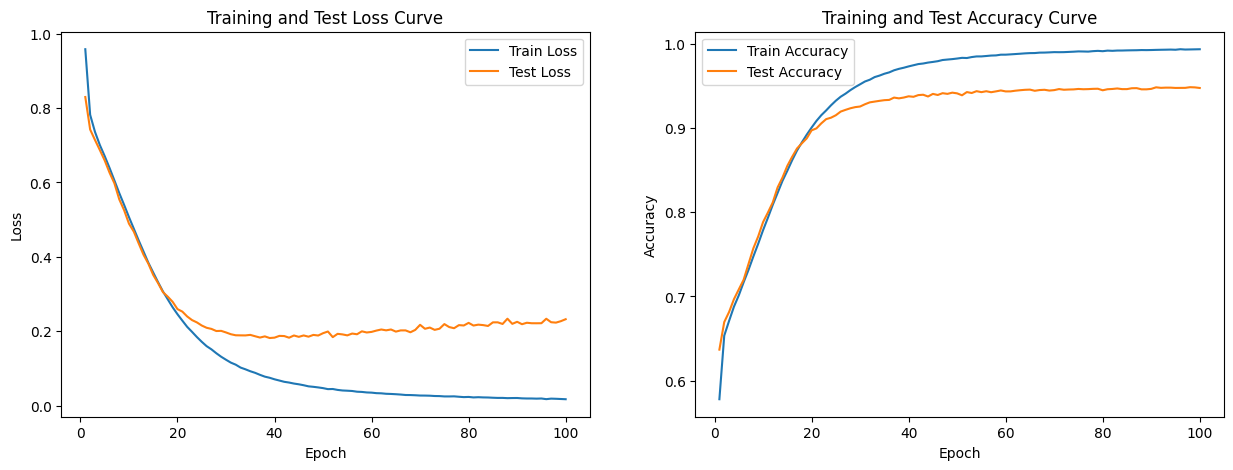

In [6]:
class LossFunction(nn.Module):
    def __init__(self, num_tasks):
        super(LossFunction, self).__init__()
        self.num_tasks = num_tasks

        self.loss_fns = [nn.CrossEntropyLoss() for x in range(num_tasks)] 

    def forward(self, predictions, labels_task1):

        #task 1
        target = labels_task1.long()
        prediction = predictions[0]
        loss_fn = self.loss_fns[0]

        task_loss = loss_fn(prediction, target)
        
        return task_loss
    
model = CATTransformer(rff_on=True,
                       sigma=2,
                       embed_size=160,
                       heads=5,
                       forward_expansion=8,
                       pre_norm_on=False,
                       mlp_scale_classification=8,
                       decoder_dropout=0,
                       classification_dropout=0.1,
                       targets_classes=target_classes,
                       n_cont=len(cont_columns),
                       embedding_scheme='rff_unique',
                       linear_on=False).to(device_in_use)

def format_metric(value): # Used to format the metrics output
    return f"{value:.5f}"

loss_functions = LossFunction(1)
optimizer = torch.optim.Adam(params=model.parameters(), lr = 0.0001) # Maybe try messing around with optimizers. try other torch optimizers with different configurations.
epochs = 100 #Set the number of epochs

train_losses = []
train_accuracies_1 = [] 
test_losses = []
test_accuracies_1 = [] 
test_f1_scores = [] 


#Time will be recorded for all 100 epochs - This means the results will not be comparable to Xgboost but that is ok, we will only compare between transformer models who will also train for 100 epochs
start_time = time.process_time()

for t in range(epochs):
  train_loss, train_accuracy_1 = train(train_dataloader, model, loss_functions, optimizer, device_in_use=device_in_use)
  test_loss, test_accuracy_1, all_predictions_1, all_targets_1, f1_1 = test(test_dataloader, model, loss_functions, device_in_use=device_in_use)
  train_losses.append(train_loss)
  train_accuracies_1.append(train_accuracy_1)
  # train_accuracies_2.append(train_accuracy_2)
  # train_recalls.append(train_recall) 
  # train_f1_scores.append(train_f1)
  test_losses.append(test_loss)
  test_accuracies_1.append(test_accuracy_1)
  # test_accuracies_2.append(test_accuracy_2)
  # test_recalls.append(test_recall)
  test_f1_scores.append(f1_1)
  # Formatting for easier reading
  epoch_str = f"Epoch [{t+1:2}/{epochs}]"
  train_metrics = f"Train: Loss {format_metric(train_loss)}, Accuracy {format_metric(train_accuracy_1)}"
  test_metrics = f"Test: Loss {format_metric(test_loss)}, Accuracy {format_metric(test_accuracy_1)}, F1 {format_metric(f1_1)}"
  print(f"{epoch_str:20} | {train_metrics:65} | {test_metrics}")

total_time = time.process_time() - start_time

# Plotting the loss curves
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), [l for l in test_losses], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curve')
plt.legend()

# Plotting the accuracy curves
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies_1, label='Train Accuracy')
plt.plot(range(1, epochs+1), test_accuracies_1, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy Curve')
plt.legend()

# Display confusion matrix for the first task (Traffic Type) on test data
conf_matrix_1 = confusion_matrix(all_targets_1, all_predictions_1)
print("Confusion Matrix for income")
print(conf_matrix_1)

best_index = test_accuracies_1.index(max(test_accuracies_1))
print(f"Best accuracy {test_accuracies_1[best_index]}")
print(f"Best F1 {test_f1_scores[best_index]}")
print(f"100 epochs of training and evaluation took, {total_time}")

# RFF - Linear

Epoch [ 1/100]       | Train: Loss 0.73879, Accuracy 0.68710                             | Test: Loss 0.63930, Accuracy 0.72625, F1 0.71309
Epoch [ 2/100]       | Train: Loss 0.60554, Accuracy 0.73887                             | Test: Loss 0.57443, Accuracy 0.75103, F1 0.73950
Epoch [ 3/100]       | Train: Loss 0.53718, Accuracy 0.77012                             | Test: Loss 0.51076, Accuracy 0.77929, F1 0.77187
Epoch [ 4/100]       | Train: Loss 0.47811, Accuracy 0.79709                             | Test: Loss 0.43706, Accuracy 0.81600, F1 0.81296
Epoch [ 5/100]       | Train: Loss 0.41170, Accuracy 0.82681                             | Test: Loss 0.37110, Accuracy 0.84722, F1 0.84592
Epoch [ 6/100]       | Train: Loss 0.34542, Accuracy 0.85699                             | Test: Loss 0.31259, Accuracy 0.87243, F1 0.87118
Epoch [ 7/100]       | Train: Loss 0.29085, Accuracy 0.88162                             | Test: Loss 0.25792, Accuracy 0.89735, F1 0.89681
Epoch [ 8/100]      

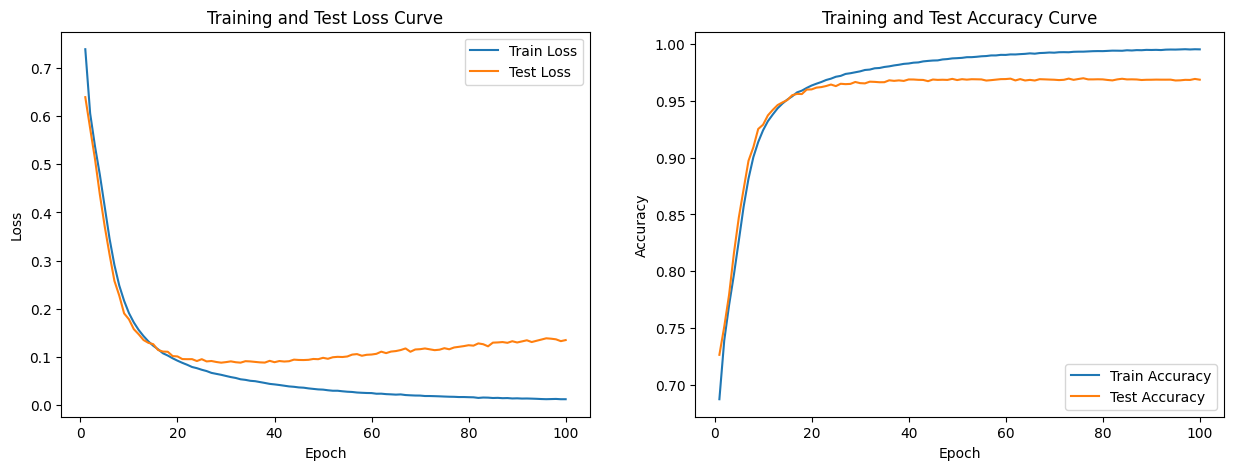

In [7]:
class LossFunction(nn.Module):
    def __init__(self, num_tasks):
        super(LossFunction, self).__init__()
        self.num_tasks = num_tasks

        self.loss_fns = [nn.CrossEntropyLoss() for x in range(num_tasks)] 

    def forward(self, predictions, labels_task1):

        #task 1
        target = labels_task1.long()
        prediction = predictions[0]
        loss_fn = self.loss_fns[0]

        task_loss = loss_fn(prediction, target)
        
        return task_loss
    
model = CATTransformer(rff_on=True,
                       sigma=2,
                       embed_size=160,
                       heads=5,
                       forward_expansion=8,
                       pre_norm_on=False,
                       mlp_scale_classification=8,
                       decoder_dropout=0,
                       classification_dropout=0.1,
                       targets_classes=target_classes,
                       n_cont=len(cont_columns),
                       embedding_scheme='rff',
                       linear_on=True).to(device_in_use)

def format_metric(value): # Used to format the metrics output
    return f"{value:.5f}"

loss_functions = LossFunction(1)
optimizer = torch.optim.Adam(params=model.parameters(), lr = 0.0001) # Maybe try messing around with optimizers. try other torch optimizers with different configurations.
epochs = 100 #Set the number of epochs

train_losses = []
train_accuracies_1 = [] 
test_losses = []
test_accuracies_1 = [] 
test_f1_scores = [] 


#Time will be recorded for all 100 epochs - This means the results will not be comparable to Xgboost but that is ok, we will only compare between transformer models who will also train for 100 epochs
start_time = time.process_time()

for t in range(epochs):
  train_loss, train_accuracy_1 = train(train_dataloader, model, loss_functions, optimizer, device_in_use=device_in_use)
  test_loss, test_accuracy_1, all_predictions_1, all_targets_1, f1_1 = test(test_dataloader, model, loss_functions, device_in_use=device_in_use)
  train_losses.append(train_loss)
  train_accuracies_1.append(train_accuracy_1)
  # train_accuracies_2.append(train_accuracy_2)
  # train_recalls.append(train_recall) 
  # train_f1_scores.append(train_f1)
  test_losses.append(test_loss)
  test_accuracies_1.append(test_accuracy_1)
  # test_accuracies_2.append(test_accuracy_2)
  # test_recalls.append(test_recall)
  test_f1_scores.append(f1_1)
  # Formatting for easier reading
  epoch_str = f"Epoch [{t+1:2}/{epochs}]"
  train_metrics = f"Train: Loss {format_metric(train_loss)}, Accuracy {format_metric(train_accuracy_1)}"
  test_metrics = f"Test: Loss {format_metric(test_loss)}, Accuracy {format_metric(test_accuracy_1)}, F1 {format_metric(f1_1)}"
  print(f"{epoch_str:20} | {train_metrics:65} | {test_metrics}")

total_time = time.process_time() - start_time

# Plotting the loss curves
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), [l for l in test_losses], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curve')
plt.legend()

# Plotting the accuracy curves
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies_1, label='Train Accuracy')
plt.plot(range(1, epochs+1), test_accuracies_1, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy Curve')
plt.legend()

# Display confusion matrix for the first task (Traffic Type) on test data
conf_matrix_1 = confusion_matrix(all_targets_1, all_predictions_1)
print("Confusion Matrix for income")
print(conf_matrix_1)

best_index = test_accuracies_1.index(max(test_accuracies_1))
print(f"Best accuracy {test_accuracies_1[best_index]}")
print(f"Best F1 {test_f1_scores[best_index]}")
print(f"100 epochs of training and evaluation took, {total_time}")

In [7]:
model = CATTransformer(rff_on=True,
                       sigma=2,
                       embed_size=160,
                       heads=5,
                       forward_expansion=8,
                       pre_norm_on=False,
                       mlp_scale_classification=8,
                       decoder_dropout=0,
                       classification_dropout=0.1,
                       targets_classes=target_classes,
                       n_cont=len(cont_columns),
                       embedding_scheme='rff',
                       linear_on=True)

count_parameters(model)

3912711

# RFF. No Linear

Epoch [ 1/100]       | Train: Loss 1.01811, Accuracy 0.53354                             | Test: Loss 0.87409, Accuracy 0.58985, F1 0.55292
Epoch [ 2/100]       | Train: Loss 0.83580, Accuracy 0.60457                             | Test: Loss 0.81543, Accuracy 0.61336, F1 0.60405
Epoch [ 3/100]       | Train: Loss 0.79439, Accuracy 0.62483                             | Test: Loss 0.77518, Accuracy 0.63709, F1 0.61794
Epoch [ 4/100]       | Train: Loss 0.76066, Accuracy 0.64262                             | Test: Loss 0.74528, Accuracy 0.65122, F1 0.62920
Epoch [ 5/100]       | Train: Loss 0.73651, Accuracy 0.65523                             | Test: Loss 0.73696, Accuracy 0.65733, F1 0.65253
Epoch [ 6/100]       | Train: Loss 0.71225, Accuracy 0.66803                             | Test: Loss 0.69689, Accuracy 0.67796, F1 0.66497
Epoch [ 7/100]       | Train: Loss 0.68923, Accuracy 0.68151                             | Test: Loss 0.67796, Accuracy 0.68821, F1 0.67995
Epoch [ 8/100]      

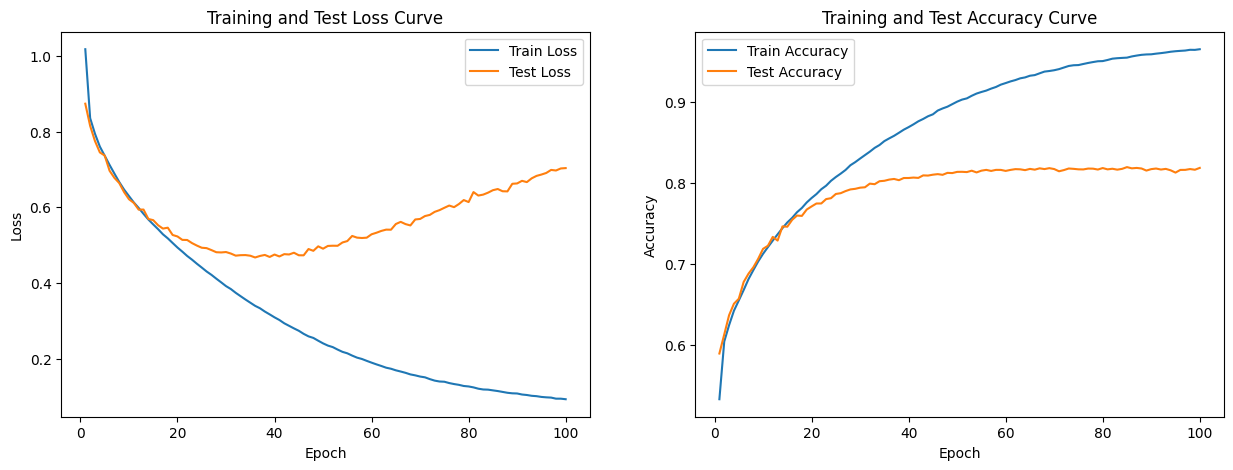

In [8]:
class LossFunction(nn.Module):
    def __init__(self, num_tasks):
        super(LossFunction, self).__init__()
        self.num_tasks = num_tasks

        self.loss_fns = [nn.CrossEntropyLoss() for x in range(num_tasks)] 

    def forward(self, predictions, labels_task1):

        #task 1
        target = labels_task1.long()
        prediction = predictions[0]
        loss_fn = self.loss_fns[0]

        task_loss = loss_fn(prediction, target)
        
        return task_loss
    
model = CATTransformer(rff_on=True,
                       sigma=2,
                       embed_size=160,
                       heads=5,
                       forward_expansion=8,
                       pre_norm_on=False,
                       mlp_scale_classification=8,
                     
                       decoder_dropout=0,
                       classification_dropout=0.1,
                       targets_classes=target_classes,
                       n_cont=len(cont_columns),
                       embedding_scheme='rff',
                       linear_on=False).to(device_in_use)

def format_metric(value): # Used to format the metrics output
    return f"{value:.5f}"

loss_functions = LossFunction(1)
optimizer = torch.optim.Adam(params=model.parameters(), lr = 0.0001) # Maybe try messing around with optimizers. try other torch optimizers with different configurations.
epochs = 100 #Set the number of epochs

train_losses = []
train_accuracies_1 = [] 
test_losses = []
test_accuracies_1 = [] 
test_f1_scores = [] 


#Time will be recorded for all 100 epochs - This means the results will not be comparable to Xgboost but that is ok, we will only compare between transformer models who will also train for 100 epochs
start_time = time.process_time()

for t in range(epochs):
  train_loss, train_accuracy_1 = train(train_dataloader, model, loss_functions, optimizer, device_in_use=device_in_use)
  test_loss, test_accuracy_1, all_predictions_1, all_targets_1, f1_1 = test(test_dataloader, model, loss_functions, device_in_use=device_in_use)
  train_losses.append(train_loss)
  train_accuracies_1.append(train_accuracy_1)
  # train_accuracies_2.append(train_accuracy_2)
  # train_recalls.append(train_recall) 
  # train_f1_scores.append(train_f1)
  test_losses.append(test_loss)
  test_accuracies_1.append(test_accuracy_1)
  # test_accuracies_2.append(test_accuracy_2)
  # test_recalls.append(test_recall)
  test_f1_scores.append(f1_1)
  # Formatting for easier reading
  epoch_str = f"Epoch [{t+1:2}/{epochs}]"
  train_metrics = f"Train: Loss {format_metric(train_loss)}, Accuracy {format_metric(train_accuracy_1)}"
  test_metrics = f"Test: Loss {format_metric(test_loss)}, Accuracy {format_metric(test_accuracy_1)}, F1 {format_metric(f1_1)}"
  print(f"{epoch_str:20} | {train_metrics:65} | {test_metrics}")

total_time = time.process_time() - start_time

# Plotting the loss curves
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), [l for l in test_losses], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curve')
plt.legend()

# Plotting the accuracy curves
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies_1, label='Train Accuracy')
plt.plot(range(1, epochs+1), test_accuracies_1, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy Curve')
plt.legend()

# Display confusion matrix for the first task (Traffic Type) on test data
conf_matrix_1 = confusion_matrix(all_targets_1, all_predictions_1)
print("Confusion Matrix for income")
print(conf_matrix_1)

best_index = test_accuracies_1.index(max(test_accuracies_1))
print(f"Best accuracy {test_accuracies_1[best_index]}")
print(f"Best F1 {test_f1_scores[best_index]}")
print(f"100 epochs of training and evaluation took, {total_time}")

# Trainable Normal Periodic Embedding. No Linear layers

Epoch [ 1/100]       | Train: Loss 0.96604, Accuracy 0.54619                             | Test: Loss 0.82590, Accuracy 0.60707, F1 0.59253
Epoch [ 2/100]       | Train: Loss 0.79565, Accuracy 0.61817                             | Test: Loss 0.76310, Accuracy 0.64083, F1 0.61941
Epoch [ 3/100]       | Train: Loss 0.74799, Accuracy 0.64964                             | Test: Loss 0.73134, Accuracy 0.66191, F1 0.64484
Epoch [ 4/100]       | Train: Loss 0.72114, Accuracy 0.66546                             | Test: Loss 0.70667, Accuracy 0.67648, F1 0.66481
Epoch [ 5/100]       | Train: Loss 0.70238, Accuracy 0.67551                             | Test: Loss 0.68875, Accuracy 0.68293, F1 0.67294
Epoch [ 6/100]       | Train: Loss 0.68584, Accuracy 0.68358                             | Test: Loss 0.67532, Accuracy 0.68883, F1 0.68020
Epoch [ 7/100]       | Train: Loss 0.67192, Accuracy 0.69188                             | Test: Loss 0.65745, Accuracy 0.69916, F1 0.69126
Epoch [ 8/100]      

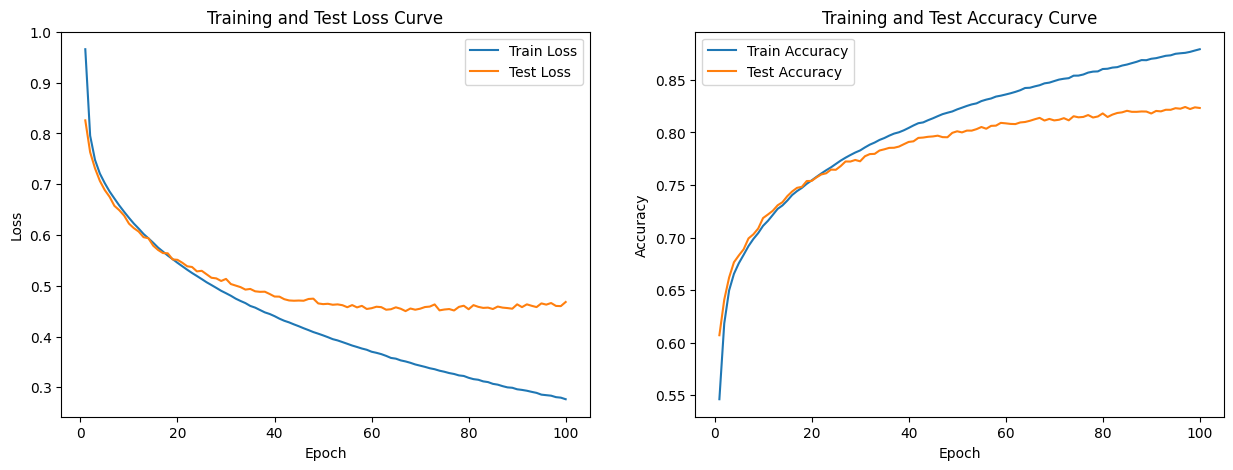

In [11]:
class LossFunction(nn.Module):
    def __init__(self, num_tasks):
        super(LossFunction, self).__init__()
        self.num_tasks = num_tasks

        self.loss_fns = [nn.CrossEntropyLoss() for x in range(num_tasks)] 

    def forward(self, predictions, labels_task1):

        #task 1
        target = labels_task1.long()
        prediction = predictions[0]
        loss_fn = self.loss_fns[0]

        task_loss = loss_fn(prediction, target)
        
        return task_loss
    
model = CATTransformer(rff_on=True,
                       sigma=2,
                       embed_size=160,
                       heads=5,
                       forward_expansion=8,
                       pre_norm_on=False,
                       mlp_scale_classification=8,
                      
                       decoder_dropout=0,
                       classification_dropout=0.1,
                       targets_classes=target_classes,
                       n_cont=len(cont_columns),
                      
                       embedding_scheme='normal_periodic',
                       trainable=True,
                       linear_on=False).to(device_in_use)

def format_metric(value): # Used to format the metrics output
    return f"{value:.5f}"

loss_functions = LossFunction(1)
optimizer = torch.optim.Adam(params=model.parameters(), lr = 0.0001) # Maybe try messing around with optimizers. try other torch optimizers with different configurations.
epochs = 100 #Set the number of epochs

train_losses = []
train_accuracies_1 = [] 
test_losses = []
test_accuracies_1 = [] 
test_f1_scores = [] 


#Time will be recorded for all 100 epochs - This means the results will not be comparable to Xgboost but that is ok, we will only compare between transformer models who will also train for 100 epochs
start_time = time.process_time()

for t in range(epochs):
  train_loss, train_accuracy_1 = train(train_dataloader, model, loss_functions, optimizer, device_in_use=device_in_use)
  test_loss, test_accuracy_1, all_predictions_1, all_targets_1, f1_1 = test(test_dataloader, model, loss_functions, device_in_use=device_in_use)
  train_losses.append(train_loss)
  train_accuracies_1.append(train_accuracy_1)
  # train_accuracies_2.append(train_accuracy_2)
  # train_recalls.append(train_recall) 
  # train_f1_scores.append(train_f1)
  test_losses.append(test_loss)
  test_accuracies_1.append(test_accuracy_1)
  # test_accuracies_2.append(test_accuracy_2)
  # test_recalls.append(test_recall)
  test_f1_scores.append(f1_1)
  # Formatting for easier reading
  epoch_str = f"Epoch [{t+1:2}/{epochs}]"
  train_metrics = f"Train: Loss {format_metric(train_loss)}, Accuracy {format_metric(train_accuracy_1)}"
  test_metrics = f"Test: Loss {format_metric(test_loss)}, Accuracy {format_metric(test_accuracy_1)}, F1 {format_metric(f1_1)}"
  print(f"{epoch_str:20} | {train_metrics:65} | {test_metrics}")

total_time = time.process_time() - start_time

# Plotting the loss curves
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), [l for l in test_losses], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curve')
plt.legend()

# Plotting the accuracy curves
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies_1, label='Train Accuracy')
plt.plot(range(1, epochs+1), test_accuracies_1, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy Curve')
plt.legend()

# Display confusion matrix for the first task (Traffic Type) on test data
conf_matrix_1 = confusion_matrix(all_targets_1, all_predictions_1)
print("Confusion Matrix for income")
print(conf_matrix_1)

best_index = test_accuracies_1.index(max(test_accuracies_1))
print(f"Best accuracy {test_accuracies_1[best_index]}")
print(f"Best F1 {test_f1_scores[best_index]}")
print(f"100 epochs of training and evaluation took, {total_time}")

# Trainable Normal Periodic Embedding - Linear

Epoch [ 1/100]       | Train: Loss 0.70901, Accuracy 0.70014                             | Test: Loss 0.62322, Accuracy 0.72465, F1 0.71807
Epoch [ 2/100]       | Train: Loss 0.55615, Accuracy 0.75735                             | Test: Loss 0.48600, Accuracy 0.79322, F1 0.78873
Epoch [ 3/100]       | Train: Loss 0.44603, Accuracy 0.80979                             | Test: Loss 0.38961, Accuracy 0.83404, F1 0.83181
Epoch [ 4/100]       | Train: Loss 0.36205, Accuracy 0.84797                             | Test: Loss 0.32142, Accuracy 0.87036, F1 0.86951
Epoch [ 5/100]       | Train: Loss 0.30321, Accuracy 0.87453                             | Test: Loss 0.26983, Accuracy 0.89166, F1 0.89092
Epoch [ 6/100]       | Train: Loss 0.26417, Accuracy 0.89169                             | Test: Loss 0.23268, Accuracy 0.90792, F1 0.90708
Epoch [ 7/100]       | Train: Loss 0.23492, Accuracy 0.90455                             | Test: Loss 0.20904, Accuracy 0.91580, F1 0.91572
Epoch [ 8/100]      

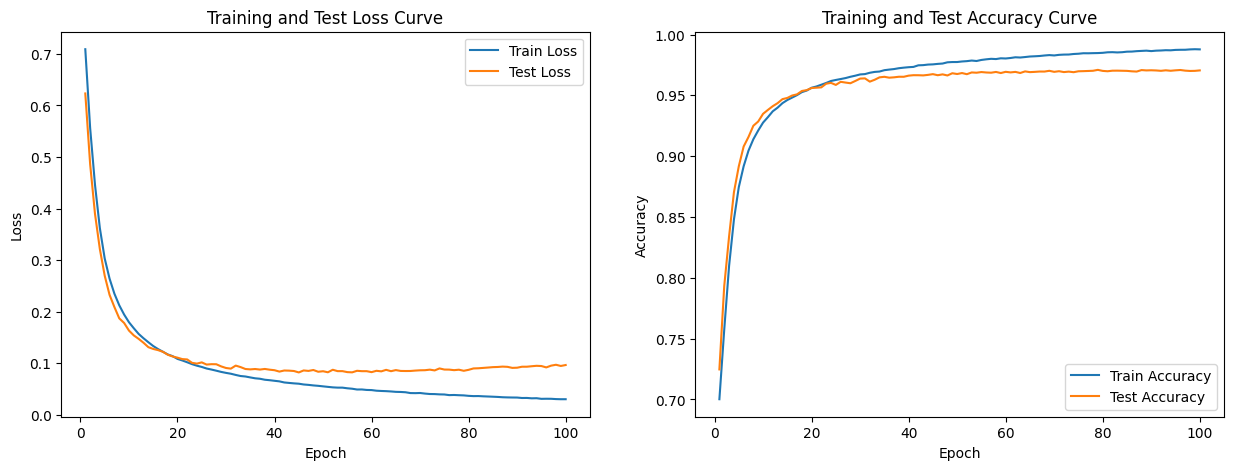

In [12]:
class LossFunction(nn.Module):
    def __init__(self, num_tasks):
        super(LossFunction, self).__init__()
        self.num_tasks = num_tasks

        self.loss_fns = [nn.CrossEntropyLoss() for x in range(num_tasks)] 

    def forward(self, predictions, labels_task1):

        #task 1
        target = labels_task1.long()
        prediction = predictions[0]
        loss_fn = self.loss_fns[0]

        task_loss = loss_fn(prediction, target)
        
        return task_loss
    
model = CATTransformer(rff_on=True,
                       sigma=2,
                       embed_size=160,
                       heads=5,
                       forward_expansion=8,
                       pre_norm_on=False,
                       mlp_scale_classification=8,
                    
                       decoder_dropout=0,
                       classification_dropout=0.1,
                       targets_classes=target_classes,
                       n_cont=len(cont_columns),
                     
                       embedding_scheme='normal_periodic',
                       trainable=True,
                       linear_on=True).to(device_in_use)

def format_metric(value): # Used to format the metrics output
    return f"{value:.5f}"

loss_functions = LossFunction(1)
optimizer = torch.optim.Adam(params=model.parameters(), lr = 0.0001) # Maybe try messing around with optimizers. try other torch optimizers with different configurations.
epochs = 100 #Set the number of epochs

train_losses = []
train_accuracies_1 = [] 
test_losses = []
test_accuracies_1 = [] 
test_f1_scores = [] 


#Time will be recorded for all 100 epochs - This means the results will not be comparable to Xgboost but that is ok, we will only compare between transformer models who will also train for 100 epochs
start_time = time.process_time()

for t in range(epochs):
  train_loss, train_accuracy_1 = train(train_dataloader, model, loss_functions, optimizer, device_in_use=device_in_use)
  test_loss, test_accuracy_1, all_predictions_1, all_targets_1, f1_1 = test(test_dataloader, model, loss_functions, device_in_use=device_in_use)
  train_losses.append(train_loss)
  train_accuracies_1.append(train_accuracy_1)
  # train_accuracies_2.append(train_accuracy_2)
  # train_recalls.append(train_recall) 
  # train_f1_scores.append(train_f1)
  test_losses.append(test_loss)
  test_accuracies_1.append(test_accuracy_1)
  # test_accuracies_2.append(test_accuracy_2)
  # test_recalls.append(test_recall)
  test_f1_scores.append(f1_1)
  # Formatting for easier reading
  epoch_str = f"Epoch [{t+1:2}/{epochs}]"
  train_metrics = f"Train: Loss {format_metric(train_loss)}, Accuracy {format_metric(train_accuracy_1)}"
  test_metrics = f"Test: Loss {format_metric(test_loss)}, Accuracy {format_metric(test_accuracy_1)}, F1 {format_metric(f1_1)}"
  print(f"{epoch_str:20} | {train_metrics:65} | {test_metrics}")

total_time = time.process_time() - start_time

# Plotting the loss curves
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), [l for l in test_losses], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curve')
plt.legend()

# Plotting the accuracy curves
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies_1, label='Train Accuracy')
plt.plot(range(1, epochs+1), test_accuracies_1, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy Curve')
plt.legend()

# Display confusion matrix for the first task (Traffic Type) on test data
conf_matrix_1 = confusion_matrix(all_targets_1, all_predictions_1)
print("Confusion Matrix for income")
print(conf_matrix_1)

best_index = test_accuracies_1.index(max(test_accuracies_1))
print(f"Best accuracy {test_accuracies_1[best_index]}")
print(f"Best F1 {test_f1_scores[best_index]}")
print(f"100 epochs of training and evaluation took, {total_time}")

In [9]:
model = CATTransformer(rff_on=True,
                       sigma=2,
                       embed_size=160,
                       heads=5,
                       forward_expansion=8,
                       pre_norm_on=False,
                       mlp_scale_classification=8,
                    
                       decoder_dropout=0,
                       classification_dropout=0.1,
                       targets_classes=target_classes,
                       n_cont=len(cont_columns),
                     
                       embedding_scheme='normal_periodic',
                       trainable=True,
                       linear_on=True)
count_parameters(model)

3912791

# Normal - no Linear

Epoch [ 1/100]       | Train: Loss 0.97508, Accuracy 0.54382                             | Test: Loss 0.81403, Accuracy 0.61002, F1 0.56887
Epoch [ 2/100]       | Train: Loss 0.78502, Accuracy 0.62551                             | Test: Loss 0.75280, Accuracy 0.64895, F1 0.62903
Epoch [ 3/100]       | Train: Loss 0.74085, Accuracy 0.65410                             | Test: Loss 0.73049, Accuracy 0.65805, F1 0.63947
Epoch [ 4/100]       | Train: Loss 0.71519, Accuracy 0.66654                             | Test: Loss 0.71221, Accuracy 0.67143, F1 0.65922
Epoch [ 5/100]       | Train: Loss 0.69626, Accuracy 0.67733                             | Test: Loss 0.68803, Accuracy 0.68153, F1 0.67294
Epoch [ 6/100]       | Train: Loss 0.68021, Accuracy 0.68558                             | Test: Loss 0.67610, Accuracy 0.68918, F1 0.67855
Epoch [ 7/100]       | Train: Loss 0.66539, Accuracy 0.69345                             | Test: Loss 0.65340, Accuracy 0.69981, F1 0.69391
Epoch [ 8/100]      

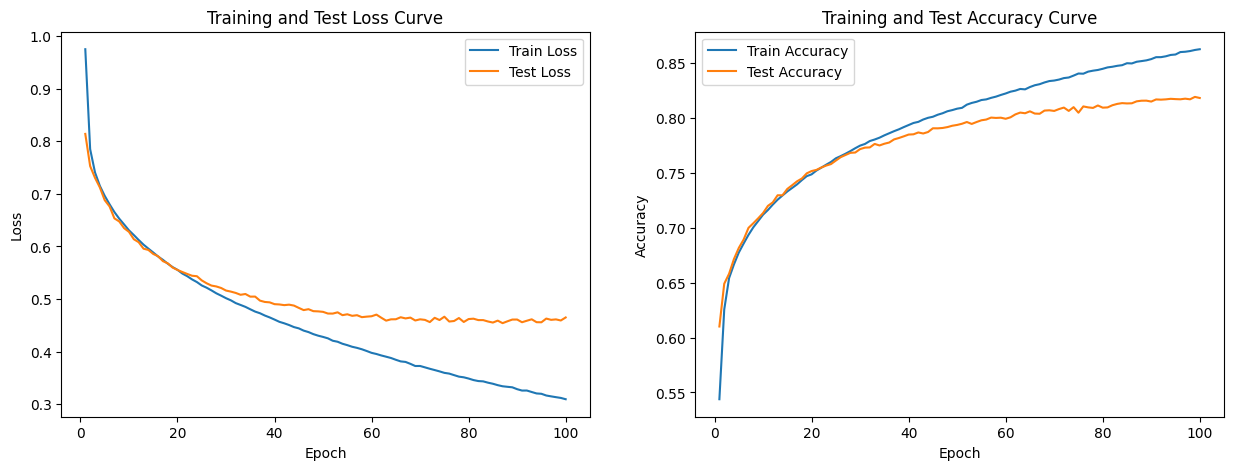

In [13]:
class LossFunction(nn.Module):
    def __init__(self, num_tasks):
        super(LossFunction, self).__init__()
        self.num_tasks = num_tasks

        self.loss_fns = [nn.CrossEntropyLoss() for x in range(num_tasks)] 

    def forward(self, predictions, labels_task1):

        #task 1
        target = labels_task1.long()
        prediction = predictions[0]
        loss_fn = self.loss_fns[0]

        task_loss = loss_fn(prediction, target)
        
        return task_loss
    
model = CATTransformer(rff_on=True,
                       sigma=2,
                       embed_size=160,
                       heads=5,
                       forward_expansion=8,
                       pre_norm_on=False,
                       mlp_scale_classification=8,
                    
                       decoder_dropout=0,
                       classification_dropout=0.1,
                       targets_classes=target_classes,
                       n_cont=len(cont_columns),
                    
                       embedding_scheme='normal_periodic',
                       trainable=False,
                       linear_on=False).to(device_in_use)

def format_metric(value): # Used to format the metrics output
    return f"{value:.5f}"

loss_functions = LossFunction(1)
optimizer = torch.optim.Adam(params=model.parameters(), lr = 0.0001) # Maybe try messing around with optimizers. try other torch optimizers with different configurations.
epochs = 100 #Set the number of epochs

train_losses = []
train_accuracies_1 = [] 
test_losses = []
test_accuracies_1 = [] 
test_f1_scores = [] 


#Time will be recorded for all 100 epochs - This means the results will not be comparable to Xgboost but that is ok, we will only compare between transformer models who will also train for 100 epochs
start_time = time.process_time()

for t in range(epochs):
  train_loss, train_accuracy_1 = train(train_dataloader, model, loss_functions, optimizer, device_in_use=device_in_use)
  test_loss, test_accuracy_1, all_predictions_1, all_targets_1, f1_1 = test(test_dataloader, model, loss_functions, device_in_use=device_in_use)
  train_losses.append(train_loss)
  train_accuracies_1.append(train_accuracy_1)
  # train_accuracies_2.append(train_accuracy_2)
  # train_recalls.append(train_recall) 
  # train_f1_scores.append(train_f1)
  test_losses.append(test_loss)
  test_accuracies_1.append(test_accuracy_1)
  # test_accuracies_2.append(test_accuracy_2)
  # test_recalls.append(test_recall)
  test_f1_scores.append(f1_1)
  # Formatting for easier reading
  epoch_str = f"Epoch [{t+1:2}/{epochs}]"
  train_metrics = f"Train: Loss {format_metric(train_loss)}, Accuracy {format_metric(train_accuracy_1)}"
  test_metrics = f"Test: Loss {format_metric(test_loss)}, Accuracy {format_metric(test_accuracy_1)}, F1 {format_metric(f1_1)}"
  print(f"{epoch_str:20} | {train_metrics:65} | {test_metrics}")

total_time = time.process_time() - start_time

# Plotting the loss curves
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), [l for l in test_losses], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curve')
plt.legend()

# Plotting the accuracy curves
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies_1, label='Train Accuracy')
plt.plot(range(1, epochs+1), test_accuracies_1, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy Curve')
plt.legend()

# Display confusion matrix for the first task (Traffic Type) on test data
conf_matrix_1 = confusion_matrix(all_targets_1, all_predictions_1)
print("Confusion Matrix for income")
print(conf_matrix_1)

best_index = test_accuracies_1.index(max(test_accuracies_1))
print(f"Best accuracy {test_accuracies_1[best_index]}")
print(f"Best F1 {test_f1_scores[best_index]}")
print(f"100 epochs of training and evaluation took, {total_time}")

# Normal - Linear

Epoch [ 1/100]       | Train: Loss 0.70106, Accuracy 0.70234                             | Test: Loss 0.60646, Accuracy 0.73702, F1 0.72868
Epoch [ 2/100]       | Train: Loss 0.56957, Accuracy 0.75167                             | Test: Loss 0.52386, Accuracy 0.77308, F1 0.76662
Epoch [ 3/100]       | Train: Loss 0.49063, Accuracy 0.78784                             | Test: Loss 0.44650, Accuracy 0.80648, F1 0.80398
Epoch [ 4/100]       | Train: Loss 0.41371, Accuracy 0.82345                             | Test: Loss 0.36943, Accuracy 0.84575, F1 0.84437
Epoch [ 5/100]       | Train: Loss 0.34923, Accuracy 0.85423                             | Test: Loss 0.31270, Accuracy 0.87137, F1 0.86971
Epoch [ 6/100]       | Train: Loss 0.29868, Accuracy 0.87716                             | Test: Loss 0.26511, Accuracy 0.89159, F1 0.89074
Epoch [ 7/100]       | Train: Loss 0.26143, Accuracy 0.89374                             | Test: Loss 0.23368, Accuracy 0.90431, F1 0.90382
Epoch [ 8/100]      

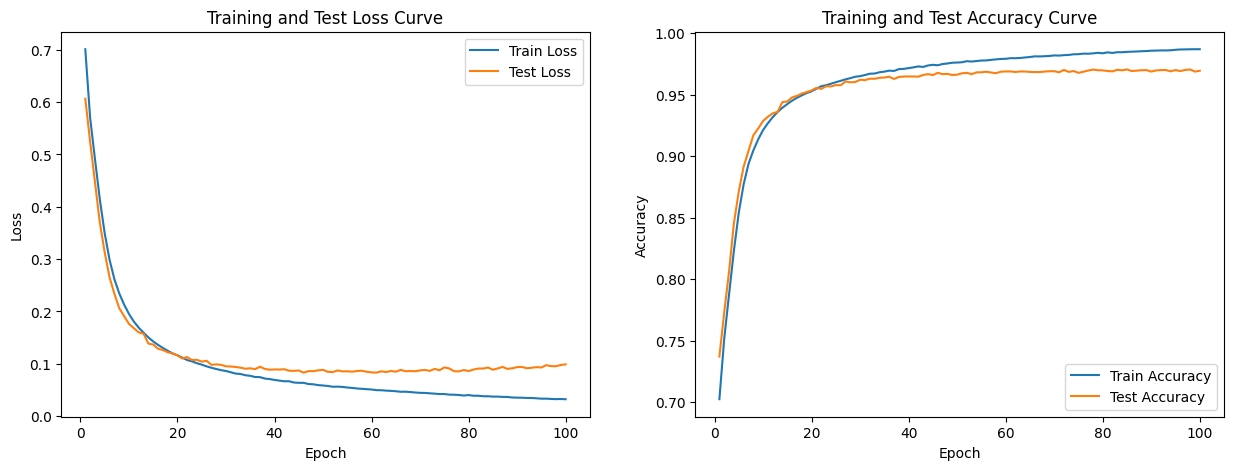

In [14]:
class LossFunction(nn.Module):
    def __init__(self, num_tasks):
        super(LossFunction, self).__init__()
        self.num_tasks = num_tasks

        self.loss_fns = [nn.CrossEntropyLoss() for x in range(num_tasks)] 

    def forward(self, predictions, labels_task1):

        #task 1
        target = labels_task1.long()
        prediction = predictions[0]
        loss_fn = self.loss_fns[0]

        task_loss = loss_fn(prediction, target)
        
        return task_loss
    
model = CATTransformer(rff_on=True,
                       sigma=2,
                       embed_size=160,
                       heads=5,
                       forward_expansion=8,
                       pre_norm_on=False,
                       mlp_scale_classification=8,
               
                       decoder_dropout=0,
                       classification_dropout=0.1,
                       targets_classes=target_classes,
                       n_cont=len(cont_columns),
                      
                       embedding_scheme='normal_periodic',
                       trainable=False,
                       linear_on=True).to(device_in_use)

def format_metric(value): # Used to format the metrics output
    return f"{value:.5f}"

loss_functions = LossFunction(1)
optimizer = torch.optim.Adam(params=model.parameters(), lr = 0.0001) # Maybe try messing around with optimizers. try other torch optimizers with different configurations.
epochs = 100 #Set the number of epochs

train_losses = []
train_accuracies_1 = [] 
test_losses = []
test_accuracies_1 = [] 
test_f1_scores = [] 


#Time will be recorded for all 100 epochs - This means the results will not be comparable to Xgboost but that is ok, we will only compare between transformer models who will also train for 100 epochs
start_time = time.process_time()

for t in range(epochs):
  train_loss, train_accuracy_1 = train(train_dataloader, model, loss_functions, optimizer, device_in_use=device_in_use)
  test_loss, test_accuracy_1, all_predictions_1, all_targets_1, f1_1 = test(test_dataloader, model, loss_functions, device_in_use=device_in_use)
  train_losses.append(train_loss)
  train_accuracies_1.append(train_accuracy_1)
  # train_accuracies_2.append(train_accuracy_2)
  # train_recalls.append(train_recall) 
  # train_f1_scores.append(train_f1)
  test_losses.append(test_loss)
  test_accuracies_1.append(test_accuracy_1)
  # test_accuracies_2.append(test_accuracy_2)
  # test_recalls.append(test_recall)
  test_f1_scores.append(f1_1)
  # Formatting for easier reading
  epoch_str = f"Epoch [{t+1:2}/{epochs}]"
  train_metrics = f"Train: Loss {format_metric(train_loss)}, Accuracy {format_metric(train_accuracy_1)}"
  test_metrics = f"Test: Loss {format_metric(test_loss)}, Accuracy {format_metric(test_accuracy_1)}, F1 {format_metric(f1_1)}"
  print(f"{epoch_str:20} | {train_metrics:65} | {test_metrics}")

total_time = time.process_time() - start_time

# Plotting the loss curves
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), [l for l in test_losses], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curve')
plt.legend()

# Plotting the accuracy curves
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies_1, label='Train Accuracy')
plt.plot(range(1, epochs+1), test_accuracies_1, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy Curve')
plt.legend()

# Display confusion matrix for the first task (Traffic Type) on test data
conf_matrix_1 = confusion_matrix(all_targets_1, all_predictions_1)
print("Confusion Matrix for income")
print(conf_matrix_1)

best_index = test_accuracies_1.index(max(test_accuracies_1))
print(f"Best accuracy {test_accuracies_1[best_index]}")
print(f"Best F1 {test_f1_scores[best_index]}")
print(f"100 epochs of training and evaluation took, {total_time}")

# Trainable Log-Linear Periodic. No Linear

Epoch [ 1/100]       | Train: Loss 1.05950, Accuracy 0.50387                             | Test: Loss 0.98410, Accuracy 0.53594, F1 0.46848
Epoch [ 2/100]       | Train: Loss 0.92803, Accuracy 0.55604                             | Test: Loss 0.86958, Accuracy 0.58541, F1 0.53053
Epoch [ 3/100]       | Train: Loss 0.84550, Accuracy 0.60208                             | Test: Loss 0.80865, Accuracy 0.62696, F1 0.60471
Epoch [ 4/100]       | Train: Loss 0.79359, Accuracy 0.63129                             | Test: Loss 0.77182, Accuracy 0.64405, F1 0.62363
Epoch [ 5/100]       | Train: Loss 0.76252, Accuracy 0.64655                             | Test: Loss 0.74384, Accuracy 0.66167, F1 0.64488
Epoch [ 6/100]       | Train: Loss 0.74083, Accuracy 0.65771                             | Test: Loss 0.73339, Accuracy 0.66429, F1 0.65424
Epoch [ 7/100]       | Train: Loss 0.72206, Accuracy 0.66733                             | Test: Loss 0.70784, Accuracy 0.67523, F1 0.66393
Epoch [ 8/100]      

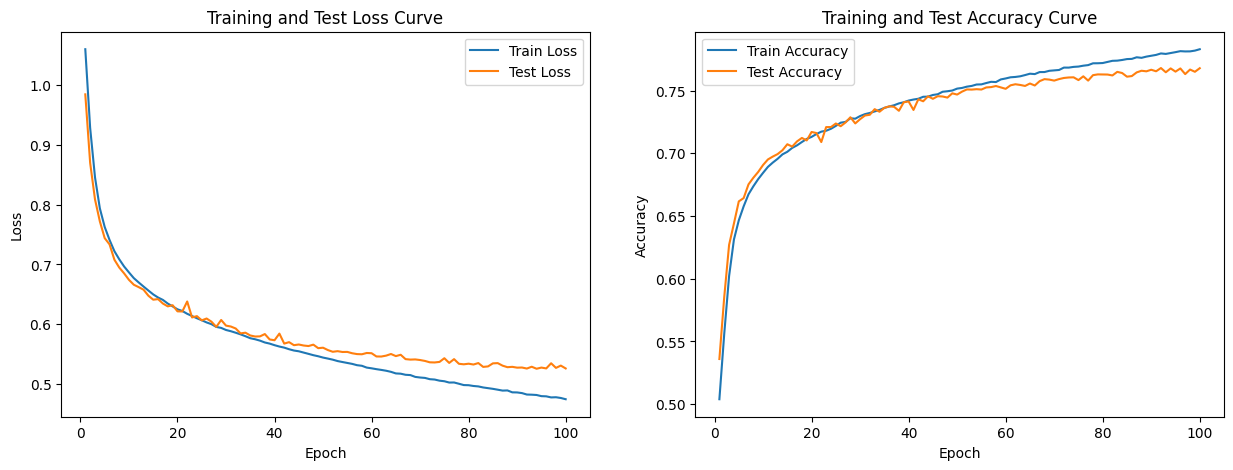

In [19]:
class LossFunction(nn.Module):
    def __init__(self, num_tasks):
        super(LossFunction, self).__init__()
        self.num_tasks = num_tasks

        self.loss_fns = [nn.CrossEntropyLoss() for x in range(num_tasks)] 

    def forward(self, predictions, labels_task1):

        #task 1
        target = labels_task1.long()
        prediction = predictions[0]
        loss_fn = self.loss_fns[0]

        task_loss = loss_fn(prediction, target)
        
        return task_loss
    
model = CATTransformer(rff_on=True,
                       sigma=2,
                       embed_size=160,
                       heads=5,
                       forward_expansion=8,
                       pre_norm_on=False,
                       mlp_scale_classification=8,
                     
                       decoder_dropout=0,
                       classification_dropout=0.1,
                       targets_classes=target_classes,
                       n_cont=len(cont_columns),
                    
                       embedding_scheme='log-linear_periodic',
                       trainable=True,
                       linear_on=False).to(device_in_use)

def format_metric(value): # Used to format the metrics output
    return f"{value:.5f}"

loss_functions = LossFunction(1)
optimizer = torch.optim.Adam(params=model.parameters(), lr = 0.0001) # Maybe try messing around with optimizers. try other torch optimizers with different configurations.
epochs = 100 #Set the number of epochs

train_losses = []
train_accuracies_1 = [] 
test_losses = []
test_accuracies_1 = [] 
test_f1_scores = [] 


#Time will be recorded for all 100 epochs - This means the results will not be comparable to Xgboost but that is ok, we will only compare between transformer models who will also train for 100 epochs
start_time = time.process_time()

for t in range(epochs):
  train_loss, train_accuracy_1 = train(train_dataloader, model, loss_functions, optimizer, device_in_use=device_in_use)
  test_loss, test_accuracy_1, all_predictions_1, all_targets_1, f1_1 = test(test_dataloader, model, loss_functions, device_in_use=device_in_use)
  train_losses.append(train_loss)
  train_accuracies_1.append(train_accuracy_1)
  # train_accuracies_2.append(train_accuracy_2)
  # train_recalls.append(train_recall) 
  # train_f1_scores.append(train_f1)
  test_losses.append(test_loss)
  test_accuracies_1.append(test_accuracy_1)
  # test_accuracies_2.append(test_accuracy_2)
  # test_recalls.append(test_recall)
  test_f1_scores.append(f1_1)
  # Formatting for easier reading
  epoch_str = f"Epoch [{t+1:2}/{epochs}]"
  train_metrics = f"Train: Loss {format_metric(train_loss)}, Accuracy {format_metric(train_accuracy_1)}"
  test_metrics = f"Test: Loss {format_metric(test_loss)}, Accuracy {format_metric(test_accuracy_1)}, F1 {format_metric(f1_1)}"
  print(f"{epoch_str:20} | {train_metrics:65} | {test_metrics}")

total_time = time.process_time() - start_time

# Plotting the loss curves
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), [l for l in test_losses], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curve')
plt.legend()

# Plotting the accuracy curves
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies_1, label='Train Accuracy')
plt.plot(range(1, epochs+1), test_accuracies_1, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy Curve')
plt.legend()

# Display confusion matrix for the first task (Traffic Type) on test data
conf_matrix_1 = confusion_matrix(all_targets_1, all_predictions_1)
print("Confusion Matrix for income")
print(conf_matrix_1)

best_index = test_accuracies_1.index(max(test_accuracies_1))
print(f"Best accuracy {test_accuracies_1[best_index]}")
print(f"Best F1 {test_f1_scores[best_index]}")
print(f"100 epochs of training and evaluation took, {total_time}")

# Trainable Log-Linear Periodic - Linear

Epoch [ 1/100]       | Train: Loss 0.70018, Accuracy 0.70035                             | Test: Loss 0.59104, Accuracy 0.74221, F1 0.73523
Epoch [ 2/100]       | Train: Loss 0.55068, Accuracy 0.76077                             | Test: Loss 0.49736, Accuracy 0.78254, F1 0.77744
Epoch [ 3/100]       | Train: Loss 0.45527, Accuracy 0.80565                             | Test: Loss 0.39577, Accuracy 0.83227, F1 0.83041
Epoch [ 4/100]       | Train: Loss 0.37279, Accuracy 0.84286                             | Test: Loss 0.32280, Accuracy 0.86727, F1 0.86588
Epoch [ 5/100]       | Train: Loss 0.31701, Accuracy 0.86839                             | Test: Loss 0.27588, Accuracy 0.88867, F1 0.88793
Epoch [ 6/100]       | Train: Loss 0.27623, Accuracy 0.88674                             | Test: Loss 0.24771, Accuracy 0.89981, F1 0.89922
Epoch [ 7/100]       | Train: Loss 0.24736, Accuracy 0.89879                             | Test: Loss 0.22706, Accuracy 0.90829, F1 0.90769
Epoch [ 8/100]      

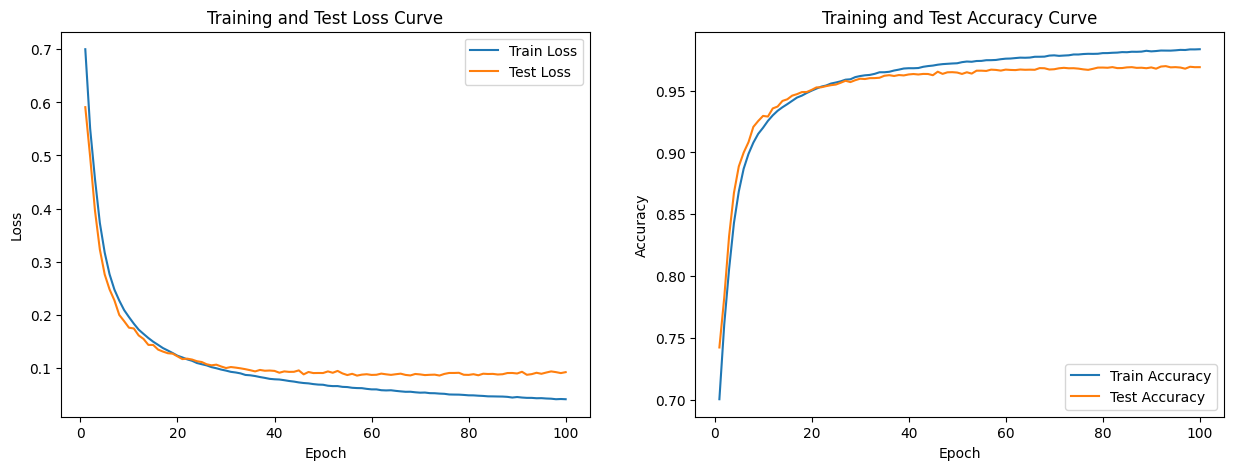

In [16]:
class LossFunction(nn.Module):
    def __init__(self, num_tasks):
        super(LossFunction, self).__init__()
        self.num_tasks = num_tasks

        self.loss_fns = [nn.CrossEntropyLoss() for x in range(num_tasks)] 

    def forward(self, predictions, labels_task1):

        #task 1
        target = labels_task1.long()
        prediction = predictions[0]
        loss_fn = self.loss_fns[0]

        task_loss = loss_fn(prediction, target)
        
        return task_loss
    
model = CATTransformer(rff_on=True,
                       sigma=2,
                       embed_size=160,
                       heads=5,
                       forward_expansion=8,
                       pre_norm_on=False,
                       mlp_scale_classification=8,
                  
                       decoder_dropout=0,
                       classification_dropout=0.1,
                       targets_classes=target_classes,
                       n_cont=len(cont_columns),
                     
                       embedding_scheme='log-linear_periodic',
                       trainable=True,
                       linear_on=True).to(device_in_use)

def format_metric(value): # Used to format the metrics output
    return f"{value:.5f}"

loss_functions = LossFunction(1)
optimizer = torch.optim.Adam(params=model.parameters(), lr = 0.0001) # Maybe try messing around with optimizers. try other torch optimizers with different configurations.
epochs = 100 #Set the number of epochs

train_losses = []
train_accuracies_1 = [] 
test_losses = []
test_accuracies_1 = [] 
test_f1_scores = [] 


#Time will be recorded for all 100 epochs - This means the results will not be comparable to Xgboost but that is ok, we will only compare between transformer models who will also train for 100 epochs
start_time = time.process_time()

for t in range(epochs):
  train_loss, train_accuracy_1 = train(train_dataloader, model, loss_functions, optimizer, device_in_use=device_in_use)
  test_loss, test_accuracy_1, all_predictions_1, all_targets_1, f1_1 = test(test_dataloader, model, loss_functions, device_in_use=device_in_use)
  train_losses.append(train_loss)
  train_accuracies_1.append(train_accuracy_1)
  # train_accuracies_2.append(train_accuracy_2)
  # train_recalls.append(train_recall) 
  # train_f1_scores.append(train_f1)
  test_losses.append(test_loss)
  test_accuracies_1.append(test_accuracy_1)
  # test_accuracies_2.append(test_accuracy_2)
  # test_recalls.append(test_recall)
  test_f1_scores.append(f1_1)
  # Formatting for easier reading
  epoch_str = f"Epoch [{t+1:2}/{epochs}]"
  train_metrics = f"Train: Loss {format_metric(train_loss)}, Accuracy {format_metric(train_accuracy_1)}"
  test_metrics = f"Test: Loss {format_metric(test_loss)}, Accuracy {format_metric(test_accuracy_1)}, F1 {format_metric(f1_1)}"
  print(f"{epoch_str:20} | {train_metrics:65} | {test_metrics}")

total_time = time.process_time() - start_time

# Plotting the loss curves
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), [l for l in test_losses], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curve')
plt.legend()

# Plotting the accuracy curves
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies_1, label='Train Accuracy')
plt.plot(range(1, epochs+1), test_accuracies_1, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy Curve')
plt.legend()

# Display confusion matrix for the first task (Traffic Type) on test data
conf_matrix_1 = confusion_matrix(all_targets_1, all_predictions_1)
print("Confusion Matrix for income")
print(conf_matrix_1)

best_index = test_accuracies_1.index(max(test_accuracies_1))
print(f"Best accuracy {test_accuracies_1[best_index]}")
print(f"Best F1 {test_f1_scores[best_index]}")
print(f"100 epochs of training and evaluation took, {total_time}")

# Log-Linear Periodic. No Linear

Epoch [ 1/100]       | Train: Loss 1.05926, Accuracy 0.50353                             | Test: Loss 0.99259, Accuracy 0.52332, F1 0.47731
Epoch [ 2/100]       | Train: Loss 0.96815, Accuracy 0.53935                             | Test: Loss 0.93370, Accuracy 0.55481, F1 0.53723
Epoch [ 3/100]       | Train: Loss 0.91569, Accuracy 0.57143                             | Test: Loss 0.89794, Accuracy 0.58344, F1 0.55209
Epoch [ 4/100]       | Train: Loss 0.88274, Accuracy 0.58969                             | Test: Loss 0.85307, Accuracy 0.60726, F1 0.58698
Epoch [ 5/100]       | Train: Loss 0.85570, Accuracy 0.60301                             | Test: Loss 0.83490, Accuracy 0.61688, F1 0.59975
Epoch [ 6/100]       | Train: Loss 0.83312, Accuracy 0.61438                             | Test: Loss 0.81426, Accuracy 0.62918, F1 0.61056
Epoch [ 7/100]       | Train: Loss 0.81168, Accuracy 0.62479                             | Test: Loss 0.79429, Accuracy 0.63584, F1 0.61529
Epoch [ 8/100]      

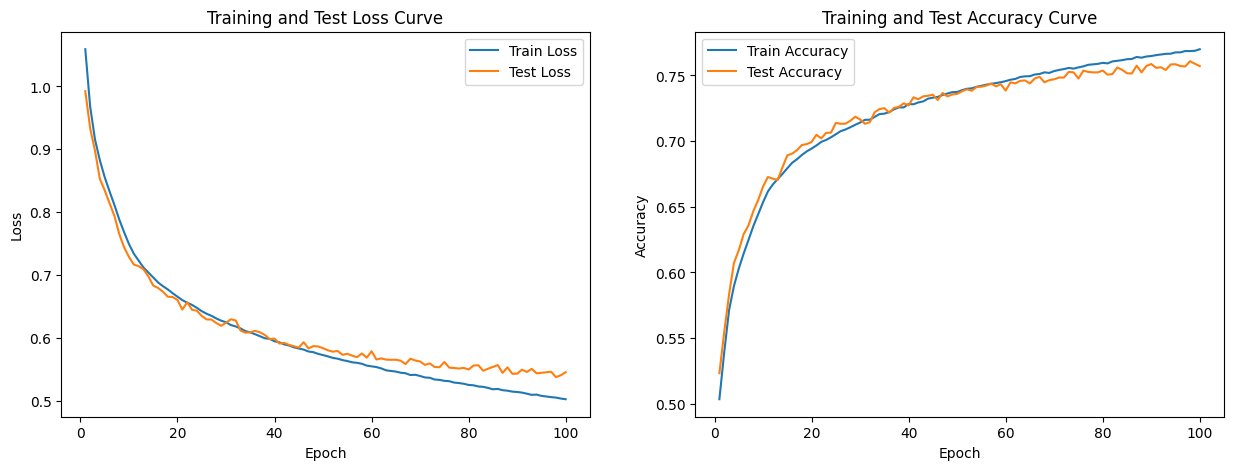

In [17]:
class LossFunction(nn.Module):
    def __init__(self, num_tasks):
        super(LossFunction, self).__init__()
        self.num_tasks = num_tasks

        self.loss_fns = [nn.CrossEntropyLoss() for x in range(num_tasks)] 

    def forward(self, predictions, labels_task1):

        #task 1
        target = labels_task1.long()
        prediction = predictions[0]
        loss_fn = self.loss_fns[0]

        task_loss = loss_fn(prediction, target)
        
        return task_loss
    
model = CATTransformer(rff_on=True,
                       sigma=2,
                       embed_size=160,
                       heads=5,
                       forward_expansion=8,
                       pre_norm_on=False,
                       mlp_scale_classification=8,
                     
                       decoder_dropout=0,
                       classification_dropout=0.1,
                       targets_classes=target_classes,
                       n_cont=len(cont_columns),
                  
                       embedding_scheme='log-linear_periodic',
                       trainable=False,
                       linear_on=False).to(device_in_use)

def format_metric(value): # Used to format the metrics output
    return f"{value:.5f}"

loss_functions = LossFunction(1)
optimizer = torch.optim.Adam(params=model.parameters(), lr = 0.0001) # Maybe try messing around with optimizers. try other torch optimizers with different configurations.
epochs = 100 #Set the number of epochs

train_losses = []
train_accuracies_1 = [] 
test_losses = []
test_accuracies_1 = [] 
test_f1_scores = [] 


#Time will be recorded for all 100 epochs - This means the results will not be comparable to Xgboost but that is ok, we will only compare between transformer models who will also train for 100 epochs
start_time = time.process_time()

for t in range(epochs):
  train_loss, train_accuracy_1 = train(train_dataloader, model, loss_functions, optimizer, device_in_use=device_in_use)
  test_loss, test_accuracy_1, all_predictions_1, all_targets_1, f1_1 = test(test_dataloader, model, loss_functions, device_in_use=device_in_use)
  train_losses.append(train_loss)
  train_accuracies_1.append(train_accuracy_1)
  # train_accuracies_2.append(train_accuracy_2)
  # train_recalls.append(train_recall) 
  # train_f1_scores.append(train_f1)
  test_losses.append(test_loss)
  test_accuracies_1.append(test_accuracy_1)
  # test_accuracies_2.append(test_accuracy_2)
  # test_recalls.append(test_recall)
  test_f1_scores.append(f1_1)
  # Formatting for easier reading
  epoch_str = f"Epoch [{t+1:2}/{epochs}]"
  train_metrics = f"Train: Loss {format_metric(train_loss)}, Accuracy {format_metric(train_accuracy_1)}"
  test_metrics = f"Test: Loss {format_metric(test_loss)}, Accuracy {format_metric(test_accuracy_1)}, F1 {format_metric(f1_1)}"
  print(f"{epoch_str:20} | {train_metrics:65} | {test_metrics}")

total_time = time.process_time() - start_time

# Plotting the loss curves
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), [l for l in test_losses], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curve')
plt.legend()

# Plotting the accuracy curves
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies_1, label='Train Accuracy')
plt.plot(range(1, epochs+1), test_accuracies_1, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy Curve')
plt.legend()

# Display confusion matrix for the first task (Traffic Type) on test data
conf_matrix_1 = confusion_matrix(all_targets_1, all_predictions_1)
print("Confusion Matrix for income")
print(conf_matrix_1)

best_index = test_accuracies_1.index(max(test_accuracies_1))
print(f"Best accuracy {test_accuracies_1[best_index]}")
print(f"Best F1 {test_f1_scores[best_index]}")
print(f"100 epochs of training and evaluation took, {total_time}")

# Log-Linear Periodic - Linear

Epoch [ 1/100]       | Train: Loss 0.69703, Accuracy 0.70673                             | Test: Loss 0.60324, Accuracy 0.74253, F1 0.73672
Epoch [ 2/100]       | Train: Loss 0.55970, Accuracy 0.75824                             | Test: Loss 0.50378, Accuracy 0.78209, F1 0.77630
Epoch [ 3/100]       | Train: Loss 0.47543, Accuracy 0.79461                             | Test: Loss 0.43131, Accuracy 0.81469, F1 0.81223
Epoch [ 4/100]       | Train: Loss 0.39748, Accuracy 0.83167                             | Test: Loss 0.34499, Accuracy 0.85832, F1 0.85673
Epoch [ 5/100]       | Train: Loss 0.33471, Accuracy 0.86089                             | Test: Loss 0.29385, Accuracy 0.87998, F1 0.87919
Epoch [ 6/100]       | Train: Loss 0.28897, Accuracy 0.88158                             | Test: Loss 0.25457, Accuracy 0.89563, F1 0.89473
Epoch [ 7/100]       | Train: Loss 0.25633, Accuracy 0.89515                             | Test: Loss 0.22647, Accuracy 0.90865, F1 0.90797
Epoch [ 8/100]      

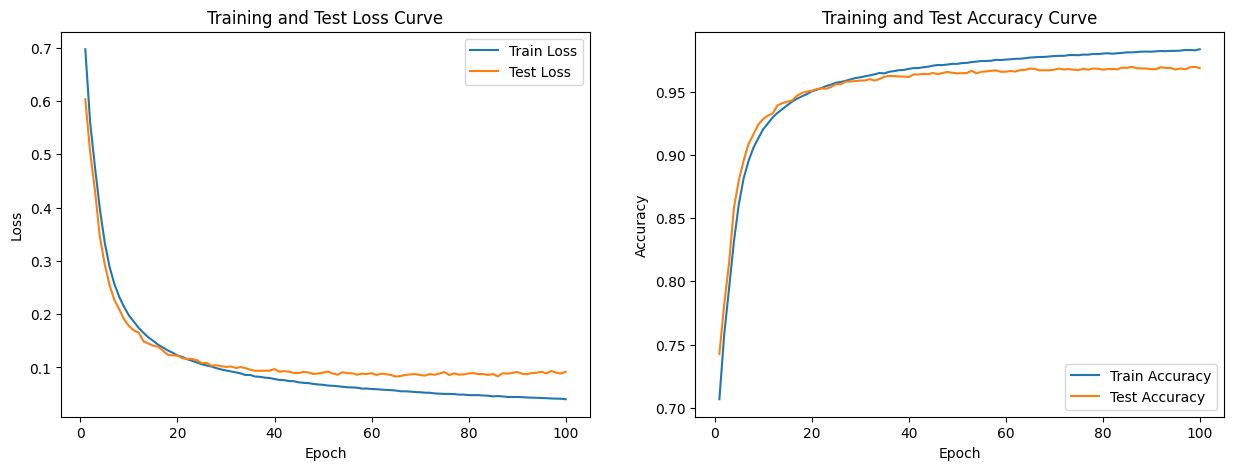

In [18]:
class LossFunction(nn.Module):
    def __init__(self, num_tasks):
        super(LossFunction, self).__init__()
        self.num_tasks = num_tasks

        self.loss_fns = [nn.CrossEntropyLoss() for x in range(num_tasks)] 

    def forward(self, predictions, labels_task1):

        #task 1
        target = labels_task1.long()
        prediction = predictions[0]
        loss_fn = self.loss_fns[0]

        task_loss = loss_fn(prediction, target)
        
        return task_loss
    
model = CATTransformer(rff_on=True,
                       sigma=2,
                       embed_size=160,
                       heads=5,
                       forward_expansion=8,
                       pre_norm_on=False,
                       mlp_scale_classification=8,
                   
                       decoder_dropout=0,
                       classification_dropout=0.1,
                       targets_classes=target_classes,
                       n_cont=len(cont_columns),
              
                       embedding_scheme='log-linear_periodic',
                       trainable=False,
                       linear_on=True).to(device_in_use)

def format_metric(value): # Used to format the metrics output
    return f"{value:.5f}"

loss_functions = LossFunction(1)
optimizer = torch.optim.Adam(params=model.parameters(), lr = 0.0001) # Maybe try messing around with optimizers. try other torch optimizers with different configurations.
epochs = 100 #Set the number of epochs

train_losses = []
train_accuracies_1 = [] 
test_losses = []
test_accuracies_1 = [] 
test_f1_scores = [] 


#Time will be recorded for all 100 epochs - This means the results will not be comparable to Xgboost but that is ok, we will only compare between transformer models who will also train for 100 epochs
start_time = time.process_time()

for t in range(epochs):
  train_loss, train_accuracy_1 = train(train_dataloader, model, loss_functions, optimizer, device_in_use=device_in_use)
  test_loss, test_accuracy_1, all_predictions_1, all_targets_1, f1_1 = test(test_dataloader, model, loss_functions, device_in_use=device_in_use)
  train_losses.append(train_loss)
  train_accuracies_1.append(train_accuracy_1)
  # train_accuracies_2.append(train_accuracy_2)
  # train_recalls.append(train_recall) 
  # train_f1_scores.append(train_f1)
  test_losses.append(test_loss)
  test_accuracies_1.append(test_accuracy_1)
  # test_accuracies_2.append(test_accuracy_2)
  # test_recalls.append(test_recall)
  test_f1_scores.append(f1_1)
  # Formatting for easier reading
  epoch_str = f"Epoch [{t+1:2}/{epochs}]"
  train_metrics = f"Train: Loss {format_metric(train_loss)}, Accuracy {format_metric(train_accuracy_1)}"
  test_metrics = f"Test: Loss {format_metric(test_loss)}, Accuracy {format_metric(test_accuracy_1)}, F1 {format_metric(f1_1)}"
  print(f"{epoch_str:20} | {train_metrics:65} | {test_metrics}")

total_time = time.process_time() - start_time

# Plotting the loss curves
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), [l for l in test_losses], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curve')
plt.legend()

# Plotting the accuracy curves
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies_1, label='Train Accuracy')
plt.plot(range(1, epochs+1), test_accuracies_1, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy Curve')
plt.legend()

# Display confusion matrix for the first task (Traffic Type) on test data
conf_matrix_1 = confusion_matrix(all_targets_1, all_predictions_1)
print("Confusion Matrix for income")
print(conf_matrix_1)

best_index = test_accuracies_1.index(max(test_accuracies_1))
print(f"Best accuracy {test_accuracies_1[best_index]}")
print(f"Best F1 {test_f1_scores[best_index]}")
print(f"100 epochs of training and evaluation took, {total_time}")